# Build a Question/Answering system over SQL data


Enabling a LLM system to query structured data can be qualitatively different from unstructured text data. 

Whereas in the latter it is common to generate text that can be searched against a vector database, 

the approach for structured data is often for the LLM to write and execute queries in a DSL, such as SQL. 


In this guide we'll go over the basic ways to create a Q&A system over tabular data in databases. 

We will cover implementations using both ```chains``` and ```agents```. 

These systems will allow us to ask a question about the data in a database and get back a natural language answer. 

The main difference between the two is that our agent can query the database in a loop as many times as it needs to answer the question.

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["LANGCHAIN_API_KEY"]=os.environ.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]="Q&A_over_SQL_data"


# Architecture
At a high-level, the steps of these systems are:

1. Convert question to DSL query: Model converts user input to a SQL query.
2. Execute SQL query: Execute the query.
3. Answer the question: Model responds to user input using the query results.


Note that querying data in CSVs can follow a similar approach. 

See our how-to guide on question-answering over CSV data for more detail.

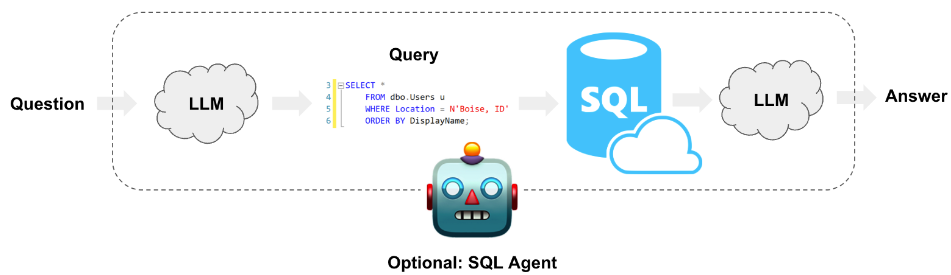


# SQL DB Creation
Create an SQL database that we can query



In [2]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Artist LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

# Hook the DB to LLM

In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

In [20]:
from langchain.chains import create_sql_query_chain

chain = create_sql_query_chain(llm, db)
response = chain.invoke({"question": "How many employees are there."})
response

'```sql\nSQLQuery: SELECT COUNT("EmployeeId") AS "EmployeeCount" FROM "Employee";\n```\n\n```sql'

In [21]:
db.run(response)

OperationalError: (sqlite3.OperationalError) near "```sql
SQLQuery: SELECT COUNT("EmployeeId") AS "EmployeeCount" FROM "Employee";
```": syntax error
[SQL: ```sql
SQLQuery: SELECT COUNT("EmployeeId") AS "EmployeeCount" FROM "Employee";
```

```sql]
(Background on this error at: https://sqlalche.me/e/20/e3q8)

We can look at the LangSmith trace to get a better understanding of what this chain is doing:

https://smith.langchain.com/public/c8fa52ea-be46-4829-bde2-52894970b830/r

We can also inspect the chain directly for its prompts. Looking at the prompt (below), we can see that it is:


1. Dialect-specific. In this case it references SQLite explicitly.
2. Has definitions for all the available tables.
2. Has three examples rows for each table.

This technique is inspired by papers like this, which suggest showing examples rows and being explicit about tables improves performance. We can also inspect the full prompt like so:


https://arxiv.org/pdf/2204.00498

In [22]:
chain.get_prompts()[0].pretty_print()

You are a SQLite expert. Given an input question, first create a syntactically correct SQLite query to run, then look at the results of the query and return the answer to the input question.
Unless the user specifies in the question a specific number of examples to obtain, query for at most 5 results using the LIMIT clause as per SQLite. You can order the results to return the most informative data in the database.
Never query for all columns from a table. You must query only the columns that are needed to answer the question. Wrap each column name in double quotes (") to denote them as delimited identifiers.
Pay attention to use only the column names you can see in the tables below. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.
Pay attention to use date('now') function to get the current date, if the question involves "today".

Use the following format:

Question: Question here
SQLQuery: SQL Query to run
SQLResult: Result

# Execute SQL query


Now that we've generated a SQL query, we'll want to execute it. This is the most dangerous part of creating a SQL chain. Consider carefully if it is OK to run automated queries over your data. Minimize the database connection permissions as much as possible. Consider adding a human approval step to you chains before query execution (see below).

We can use the ```QuerySQLDatabaseTool``` to easily add query execution to our chain:



In [23]:
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool

execute_query = QuerySQLDataBaseTool(db=db)
write_query = create_sql_query_chain(llm, db)
chain = write_query | execute_query
chain.invoke({"question": "How many employees are there."})

'Error: (sqlite3.OperationalError) near "```sql\nSELECT COUNT("EmployeeId") AS "EmployeeCount" FROM "Employee";\n```": syntax error\n[SQL: ```sql\nSELECT COUNT("EmployeeId") AS "EmployeeCount" FROM "Employee";\n```]\n(Background on this error at: https://sqlalche.me/e/20/e3q8)'

# Query checker

Perhaps the simplest strategy is to ask the model itself to check the original query for common mistakes. Suppose we have the following SQL query chain:

And we want to validate its outputs. We can do so by extending the chain with a second prompt and model call:



In [28]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

system = """Double check the user's {dialect} query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins
- Giving output of query in backticks like ```query```


If there are any of the above mistakes, rewrite the query.
Give only the SQL query and no other characters. Not even header like SQLQuery: etc
Don't use backticks around the query ```
If there are no mistakes, just reproduce the original query with no further commentary.

Output the final SQL query only."""
prompt = ChatPromptTemplate.from_messages(
    [("system", system), ("human", "{query}")]
).partial(dialect=db.dialect)
validation_chain = prompt | llm | StrOutputParser()

full_chain = {"query": chain} | validation_chain

In [29]:
query = full_chain.invoke(
    {
        "question": "What's the average Invoice from an American customer whose Fax is missing since 2003 but before 2010"
    }
)
print(query)

SELECT AVG("Total") AS "AverageInvoice"
FROM "Invoice" 
WHERE "CustomerId" IN (
    SELECT "CustomerId" 
    FROM "Customer" 
    WHERE "Country" = 'United States' 
      AND "Fax" IS NULL
) 
AND "InvoiceDate" >= '2003-01-01' 
AND "InvoiceDate" < '2010-01-01';


# Answer the question

Now that we've got a way to automatically generate and execute queries, we just need to combine the original question and SQL query result to generate a final answer. We can do this by passing question and result to the LLM once more:

In [14]:
from operator import itemgetter

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough

answer_prompt = PromptTemplate.from_template(
    """Given the following user question, corresponding SQL query, and SQL result, answer the user question. 

Question: {question}
SQL Query: {query}
SQL Result: {result}
Answer: """
)

chain = (
    RunnablePassthrough.assign(query=write_query).assign(
        result=itemgetter("query") | execute_query
    )
    | answer_prompt
    | llm
    | StrOutputParser()
)


'The SQL query you provided contains extra formatting that is causing a syntax error. The correct SQL query to count the number of employees should be:\n\n```sql\nSELECT COUNT("EmployeeId") AS "TotalEmployees" FROM "Employee";\n```\n\nHowever, it seems that the execution of the query has failed, and the actual number of employees could not be retrieved due to this error. Therefore, I cannot provide the exact count of employees at this time. You would need to run the corrected SQL query without the extra formatting to obtain the total number of employees.'

In [16]:

chain.invoke({"question": "How many employees are there."})

'It seems there was an error in executing the SQL query due to incorrect syntax. The actual SQL query should not include the surrounding code block formatting. The correct SQL query to count the number of employees should be:\n\n```sql\nSELECT COUNT("EmployeeId") AS "TotalEmployees" FROM "Employee";\n```\n\nHowever, since the query resulted in an error, it indicates that there might be an issue with the way the SQL was formatted or executed in the context being used. \n\nTo answer your question: The intended query aims to find the total number of employees in the "Employee" table. To retrieve that information successfully, please ensure that the SQL query is executed without the formatting characters. If you fix the syntax error and run the query correctly, it will return the total number of employees.'